In [1]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [264]:
data  = pd.read_csv('Data_diff.csv',sep = ',',header=0)
#data = data.sample(frac = 1) #打乱数据
data.head()

,aqi,pre_aqi,so2,no2,co,o3,pm10,pm2_5,temp_diff,humi_diff,w_dir_diff,wind_diff,rain_diff
0,48,46,12,27,0.7,26,42,33,0,1,0,0,0.0
1,53,48,16,26,0.7,29,52,37,1,-1,0,0,0.1
2,52,53,17,17,0.6,42,53,36,0,-1,0,0,-0.1
3,49,52,15,13,0.6,52,49,34,0,0,0,0,0.0
4,45,49,16,14,0.6,58,45,30,0,1,0,0,0.0


In [265]:
H = [5,6,7,8,9,10,11,12,13,14]
inputnum = 12
hiddennum = H[6]
outputnum = 1
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum 
LossArr = []
M = 4

X = data.iloc[:8383,1:]
Y = data.iloc[:8383,0]
TestX = data.iloc[8349:,1:]
TestY = data.iloc[8349:,0]
TestX.head()

,pre_aqi,so2,no2,co,o3,pm10,pm2_5,temp_diff,humi_diff,w_dir_diff,wind_diff,rain_diff
8349,87,15,31,1.2,5,76,60,-1,0,180,1,0.0
8350,82,14,33,1.2,6,71,53,0,-1,-225,1,0.0
8351,73,16,33,1.2,8,53,38,0,-3,0,-1,0.0
8352,54,15,29,1.1,13,41,27,-1,-1,0,0,0.0
8353,41,13,24,1.0,24,33,23,0,4,225,0,0.0


In [266]:

# O3max = np.max(np.abs(O3Y),axis=0)
# O3mean = np.mean(O3Y,axis=0)

def data_progress(X,TestX):
    for i in range(0,X.shape[1]):
        TestX.iloc[:,i] -= np.mean(X,axis=0)[i]
        TestX.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]
        X.iloc[:,i] -= np.mean(X,axis=0)[i]
        X.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]

        
    return 0
def data_progressY(Y,TestY):
    Y -= np.mean(Y,axis=0)
    Y /= np.max(np.abs(Y),axis=0)
    TestY -= np.mean(Y,axis=0)
    TestY /= np.max(np.abs(Y),axis=0)
    return 1
data_progress(X,TestX)


0

#  CS

In [267]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1,alpha=0.77,xn=0.33):

    num=1
    # get initial nests' locations 
    nests,best_nest,best_fitness,lossness = generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary) #alpha,xn用于tent初始化阈值和初值设置
    
    # get the best nest and record it
    LossArr.append(best_fitness) #全局变量，保存每代最佳适应度值
    

    print('\r\n BEST_LOSSNESS IS %.2f : \r\n',best_fitness)

    for _ in range(iter_num):
        
        print('\r\n******************************************************第 %d 代开始迭代优化************************************************************\r\n'%num)
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        
        print('\r\n*****************************************************第 %d 次迭代，计算适应度********************************************************\r\n'%num)
        lossness,_ = calc_fitness( nests)
        print('\r\n*********************************************************第 %d 次迭代结束************************************************************\r\n'%num)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        LossArr.append(min_loss)
            
        if min_loss < best_fitness  : #and  min_loss_fit > best_two_fitness
            best_nest = min_nestloss
            best_fitness = min_loss
            print('\r\n******')
            print('\r\n 第 %d 次迭代最优Loss是 %.2f : \r\n'%(num,best_fitness))
            print('\r\n******\r\n')
        num+=1

    return (best_nest, best_fitness)

In [268]:
def generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary):

# #随机生成nest
#     lower_boundary = np.array(lower_boundary)
#     upper_boundary = np.array(upper_boundary)
#     nests = np.empty((n, m))

#     for each_nest in range(n):
#         nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

#Tent混沌反向初始化

# # #混沌初始化
    nests = np.empty((n, m))
    sig_nest = np.empty(m)
    alpha = alpha
    xn = xn
    for i in range(0,n):   #*2 值域为【-1,1】 *6 值域为[-3,3]
        for j in range(0,m):
            if 0<=xn<alpha:
                xn = xn/alpha
                sig_nest[j]=(xn-0.5)*6
            elif alpha <= xn <= 1:
                xn = (1-xn)/(1-alpha)
                sig_nest[j] = (xn-0.5)*6
            nests[i] = sig_nest
            
# #反向初始化            
    renests = -1 * nests   #定义：Pi = ai + bi - pi  生成反向nests
    
# #拼接两个初始化nests
    nests = np.vstack((nests,renests))  #拼接nests和renests 准备计算适应度选择最优的n个nest
    
#计算适应度
    lossness,_ = calc_fitness( nests) 
    
# # #根据loss值排序
    arrIndex = np.argsort(lossness)   #获得排序数组  从小到大
    lossness = lossness[arrIndex]     #将lossness数组按照从小到大排序
    nests = nests[arrIndex]    #将nests也按照相同序列进行排序，保证和lossness对齐
    
#删除多余的n组nest，这里从最底下开始一个个删，因为已经排好序了，所以删除的为效果最差的
    for i in range(n):
        nests = np.delete(nests,-1,0)
        lossness = np.delete(lossness,-1,0)
#现在的nests是按照loss排序的，第一个loss最小

    return nests,nests[0],lossness[0],lossness

In [269]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_coefficient,bestfitness):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] # * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_losses,new_nests = calc_fitness(new_nests)
    #适应度更好的才更新过去
    
    nests[new_losses < lossness] = new_nests[new_losses < lossness] 
    return nests

In [270]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [271]:
def levy_flight(n, m, beta):

    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [272]:
def calc_fitness(nests):
    
    n, m = nests.shape
    lossness = np.empty(n)
    new_nests = nests
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',)
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！下面两句输入数据集
        model.fit(X,Y,epochs=1)
        loss = model.evaluate(X,Y)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        
        
        (k1,y1) = layer1.get_weights()  #获取训练后的神经网络权值，并赋值给c
        (k2,y2) = layer2.get_weights()
        c=k1.reshape(1,-1).tolist()[0] + y1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + y2.reshape(1,-1).tolist()[0]
        new_nests[Sig_nest] = c
        
        
#         if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
#             #model.save_weights('my_model_fun.h5')
#             bestfitness = acc
    return lossness,new_nests

In [273]:
low = -5*np.ones(numsum)
upp = 5*np.ones(numsum)
i = 0
j = 0
best_nest = [] #保存每次CS最佳loss对应的nest，用于赋值给不同神经网络构成多个弱分类器
best_loss = []
best_fitness = []
alpha = [0.22,0.46,0.65,0.72,0.90]  #alpha不取0.5,0<alpha<1
xn = [0.90,0.70,0.55,0.34,0.19]  #xn值不能和alpha值相同，否则将演化为周期系统，就不是混沌系统了
for i in range(M):
    print('第 %d 个CS算法开始'%(i+1))
    nest,loss = cuckoo_search(10,numsum, low,upp, step_size = 0.4,alpha=alpha[i],xn=xn[i])
    best_nest.append(nest)
    best_loss.append(loss)

for j in range(M):    
    print('第 %d 个CS最优loss为:%.5f!'%(j+1,best_loss[j]))

第 1 个CS算法开始
262/262 [==============================] - 0s 605us/step - loss: 113.9297

 BEST_LOSSNESS IS %.2f : 
 20.49301528930664

******************************************************第 1 代开始迭代优化************************************************************

262/262 [==============================] - 1s 816us/step - loss: 68.2104


262/262 [==============================] - 0s 819us/step - loss: 7.9469

*****************************************************第 1 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 708us/step - loss: 6.7700

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 6.77 : 


******


******************************************************第 2 代开始迭代优化************************************************************

262/262 [==============================] - 0s 835us/step - loss: 6.6994

*****************************************************第 2 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 758us/step - loss: 7.1688


262/262 [==============================] - 0s 1ms/step - loss: 16.0539

*********************************************************第 2 次迭代结束************************************************************


******

 第 2 次迭代最优Loss是 5.62 : 


******


******************************************************第 3 代开始迭代优化************************************************************

262/262 [==============================] - 0s 724us/step - loss: 9.1933

*****************************************************第 3 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 724us/step - loss: 7.5074

*********************************************************第 3 次迭代结束************************************************************


******

 第 3 次迭代最优Loss是 4.82 : 


******


******************************************************第 4 代开始迭代优化************************************************************



262/262 [==============================] - 0s 632us/step - loss: 7.5688

*****************************************************第 4 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 647us/step - loss: 6.7613

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 4.63 : 


******


******************************************************第 5 代开始迭代优化************************************************************

262/262 [==============================] - 0s 643us/step - loss: 6.6833


262/262 [==============================] - 0s 624us/step - loss: 6.5818

*****************************************************第 5 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 712us/step - loss: 6.7934

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 4.10 : 


******


******************************************************第 6 代开始迭代优化************************************************************

262/262 [==============================] - 0s 647us/step - loss: 6.4389

*****************************************************第 6 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 793us/step - loss: 72.5624


262/262 [==============================] - 0s 636us/step - loss: 6.1671

*********************************************************第 6 次迭代结束************************************************************


******

 第 6 次迭代最优Loss是 3.85 : 


******


******************************************************第 7 代开始迭代优化************************************************************

262/262 [==============================] - 0s 620us/step - loss: 6.2073

*****************************************************第 7 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 636us/step - loss: 6.4793

*********************************************************第 7 次迭代结束************************************************************


******

 第 7 次迭代最优Loss是 3.69 : 


******


******************************************************第 8 代开始迭代优化************************************************************



262/262 [==============================] - 0s 605us/step - loss: 6.0398

*****************************************************第 8 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 5.9016

*********************************************************第 8 次迭代结束************************************************************


******

 第 8 次迭代最优Loss是 3.50 : 


******


******************************************************第 9 代开始迭代优化************************************************************

262/262 [==============================] - 0s 743us/step - loss: 10.6356


262/262 [==============================] - 0s 567us/step - loss: 5.8460

*****************************************************第 9 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 685us/step - loss: 5.9037

*********************************************************第 9 次迭代结束************************************************************


******

 第 9 次迭代最优Loss是 3.46 : 


******


******************************************************第 10 代开始迭代优化************************************************************

262/262 [==============================] - 0s 651us/step - loss: 5.8044

*****************************************************第 10 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 571us/step - loss: 4.6643


262/262 [==============================] - 0s 647us/step - loss: 5.5289

*********************************************************第 10 次迭代结束************************************************************


******

 第 10 次迭代最优Loss是 3.28 : 


******


******************************************************第 11 代开始迭代优化************************************************************

262/262 [==============================] - 0s 571us/step - loss: 5.6615

*****************************************************第 11 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 701us/step - loss: 5.6791


262/262 [==============================] - 0s 571us/step - loss: 5.3498

*********************************************************第 11 次迭代结束************************************************************


******************************************************第 12 代开始迭代优化************************************************************

262/262 [==============================] - 0s 578us/step - loss: 6.1679

*****************************************************第 12 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 601us/step - loss: 5.2254

*********************************************************第 12 次迭代结束************************************************************


******

 第 12 次迭代最优Loss是 3.06 : 


******


******************************************************第 13 代开始迭代优化************************************************************

262/262 [==============================] - 0s 728us/step - loss: 4.5930


262/262 [==============================] - 0s 685us/step - loss: 5.6047

*****************************************************第 13 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 789us/step - loss: 5.2237

*********************************************************第 13 次迭代结束************************************************************


******************************************************第 14 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 6.3066

*****************************************************第 14 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 620us/step - loss: 5.7057


262/262 [==============================] - 0s 613us/step - loss: 4.9940

*********************************************************第 14 次迭代结束************************************************************


******

 第 14 次迭代最优Loss是 2.98 : 


******


******************************************************第 15 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 5.1046

*****************************************************第 15 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 716us/step - loss: 69.8512


262/262 [==============================] - 0s 540us/step - loss: 16.0613

*********************************************************第 15 次迭代结束************************************************************


******

 第 15 次迭代最优Loss是 2.80 : 


******


******************************************************第 16 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 9.9135

*****************************************************第 16 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 551us/step - loss: 8.6548

*********************************************************第 16 次迭代结束************************************************************


******

 第 16 次迭代最优Loss是 2.71 : 


******


******************************************************第 17 代开始迭代优化************************************************************

262/262 [==============================] - 0s 544us

262/262 [==============================] - 0s 548us/step - loss: 7.8217

*****************************************************第 17 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 559us/step - loss: 7.7322

*********************************************************第 17 次迭代结束************************************************************


******

 第 17 次迭代最优Loss是 2.55 : 


******


******************************************************第 18 代开始迭代优化************************************************************

262/262 [==============================] - 0s 731us/step - loss: 7.4748

*****************************************************第 18 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 930us/step - loss: 4.1163


262/262 [==============================] - 0s 632us/step - loss: 7.6020

*********************************************************第 18 次迭代结束************************************************************


******

 第 18 次迭代最优Loss是 2.33 : 


******


******************************************************第 19 代开始迭代优化************************************************************

262/262 [==============================] - 0s 559us/step - loss: 7.6542

*****************************************************第 19 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 597us/step - loss: 3.9648


262/262 [==============================] - 0s 567us/step - loss: 7.6975

*********************************************************第 19 次迭代结束************************************************************


******************************************************第 20 代开始迭代优化************************************************************

262/262 [==============================] - 0s 628us/step - loss: 7.5528

*****************************************************第 20 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 7.0084

*********************************************************第 20 次迭代结束************************************************************


******************************************************第 21 代开始迭代优化************************************************************

262/262 [==============================] - 0s 632us/step - loss: 2.7982


262/262 [==============================] - 0s 555us/step - loss: 7.7143

*****************************************************第 21 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 609us/step - loss: 6.9749

*********************************************************第 21 次迭代结束************************************************************


******

 第 21 次迭代最优Loss是 2.17 : 


******


******************************************************第 22 代开始迭代优化************************************************************

262/262 [==============================] - 0s 601us/step - loss: 6.9756

*****************************************************第 22 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 555us/step - loss: 6.9015

*********************************************************第 22 次迭代结束************************************************************


******

 第 22 次迭代最优Loss是 2.06 : 


******


******************************************************第 23 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 6.6268

*****************************************************第 23 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 693us/step - loss: 6.1329


262/262 [==============================] - 0s 571us/step - loss: 6.3108

*********************************************************第 23 次迭代结束************************************************************


******************************************************第 24 代开始迭代优化************************************************************

262/262 [==============================] - 0s 620us/step - loss: 6.2504

*****************************************************第 24 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 624us/step - loss: 5.8943

*********************************************************第 24 次迭代结束************************************************************


******************************************************第 25 代开始迭代优化************************************************************

262/262 [==============================] - 1s 712us/step - loss: 11.0929


262/262 [==============================] - 0s 563us/step - loss: 7.7031

*****************************************************第 25 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 578us/step - loss: 5.4272

*********************************************************第 25 次迭代结束************************************************************


******************************************************第 26 代开始迭代优化************************************************************

262/262 [==============================] - 0s 724us/step - loss: 11.5471


262/262 [==============================] - 0s 567us/step - loss: 5.7063

*****************************************************第 26 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 532us/step - loss: 5.2235

*********************************************************第 26 次迭代结束************************************************************


******

 第 26 次迭代最优Loss是 2.01 : 


******


******************************************************第 27 代开始迭代优化************************************************************

262/262 [==============================] - 0s 666us/step - loss: 6.5283

*****************************************************第 27 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 7.3035


262/262 [==============================] - 0s 571us/step - loss: 4.9255

*********************************************************第 27 次迭代结束************************************************************


******

 第 27 次迭代最优Loss是 1.98 : 


******


******************************************************第 28 代开始迭代优化************************************************************

262/262 [==============================] - 0s 551us/step - loss: 5.4553

*****************************************************第 28 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 601us/step - loss: 4.8081

*********************************************************第 28 次迭代结束************************************************************


******

 第 28 次迭代最优Loss是 1.79 : 


******


******************************************************第 29 代开始迭代优化************************************************************

262/262 [==============================] - 0s 605us/

262/262 [==============================] - 0s 578us/step - loss: 5.2245

*****************************************************第 29 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 632us/step - loss: 9.6982

*********************************************************第 29 次迭代结束************************************************************


******

 第 29 次迭代最优Loss是 1.47 : 


******


******************************************************第 30 代开始迭代优化************************************************************

262/262 [==============================] - 0s 697us/step - loss: 10.4571


262/262 [==============================] - 0s 574us/step - loss: 8.0591

*****************************************************第 30 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 620us/step - loss: 7.0546

*********************************************************第 30 次迭代结束************************************************************


******

 第 30 次迭代最优Loss是 1.29 : 


******

第 2 个CS算法开始
262/262 [==============================] - 0s 858us/step - loss: 38.3732


262/262 [==============================] - 0s 682us/step - loss: 32.8813

 BEST_LOSSNESS IS %.2f : 
 16.222333908081055

******************************************************第 1 代开始迭代优化************************************************************

262/262 [==============================] - 0s 716us/step - loss: 8.6630

*****************************************************第 1 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 574us/step - loss: 6.9471

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 6.68 : 


******


******************************************************第 2 代开始迭代优化************************************************************

262/262 [==============================] - 0s 605us/step - loss: 7.4205


262/262 [==============================] - 0s 571us/step - loss: 6.5438

*****************************************************第 2 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 628us/step - loss: 6.2836

*********************************************************第 2 次迭代结束************************************************************


******

 第 2 次迭代最优Loss是 5.49 : 


******


******************************************************第 3 代开始迭代优化************************************************************

262/262 [==============================] - 1s 854us/step - loss: 15.6557


262/262 [==============================] - 0s 563us/step - loss: 6.1896

*****************************************************第 3 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 597us/step - loss: 5.9296

*********************************************************第 3 次迭代结束************************************************************


******

 第 3 次迭代最优Loss是 4.73 : 


******


******************************************************第 4 代开始迭代优化************************************************************

262/262 [==============================] - 0s 639us/step - loss: 6.5078

*****************************************************第 4 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 693us/step - loss: 6.5572


262/262 [==============================] - 0s 582us/step - loss: 6.1246

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 4.25 : 


******


******************************************************第 5 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 5.7226

*****************************************************第 5 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 639us/step - loss: 5.8559

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 3.83 : 


******


******************************************************第 6 代开始迭代优化************************************************************



262/262 [==============================] - 0s 563us/step - loss: 5.5605

*****************************************************第 6 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 609us/step - loss: 4.9089

*********************************************************第 6 次迭代结束************************************************************


******

 第 6 次迭代最优Loss是 3.42 : 


******


******************************************************第 7 代开始迭代优化************************************************************

262/262 [==============================] - 0s 731us/step - loss: 5.8888


262/262 [==============================] - 0s 609us/step - loss: 4.6458

*****************************************************第 7 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 563us/step - loss: 4.1935

*********************************************************第 7 次迭代结束************************************************************


******

 第 7 次迭代最优Loss是 3.28 : 


******


******************************************************第 8 代开始迭代优化************************************************************

262/262 [==============================] - 0s 632us/step - loss: 4.8052

*****************************************************第 8 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 613us/step - loss: 13.8619


262/262 [==============================] - 0s 617us/step - loss: 3.7727

*********************************************************第 8 次迭代结束************************************************************


******

 第 8 次迭代最优Loss是 3.02 : 


******


******************************************************第 9 代开始迭代优化************************************************************

262/262 [==============================] - 0s 639us/step - loss: 3.8496

*****************************************************第 9 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 724us/step - loss: 4.0106


262/262 [==============================] - 0s 620us/step - loss: 3.5794

*********************************************************第 9 次迭代结束************************************************************


******

 第 9 次迭代最优Loss是 3.01 : 


******


******************************************************第 10 代开始迭代优化************************************************************

262/262 [==============================] - 0s 544us/step - loss: 3.7411

*****************************************************第 10 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 578us/step - loss: 3.3641

*********************************************************第 10 次迭代结束************************************************************


******************************************************第 11 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 5.1082


262/262 [==============================] - 0s 567us/step - loss: 3.6726

*****************************************************第 11 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 536us/step - loss: 3.0361

*********************************************************第 11 次迭代结束************************************************************


******************************************************第 12 代开始迭代优化************************************************************

262/262 [==============================] - 0s 728us/step - loss: 3.2107

*****************************************************第 12 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 728us/step - loss: 7.0504


262/262 [==============================] - 0s 574us/step - loss: 4.4189

*********************************************************第 12 次迭代结束************************************************************


******

 第 12 次迭代最优Loss是 2.81 : 


******


******************************************************第 13 代开始迭代优化************************************************************

262/262 [==============================] - 0s 697us/step - loss: 3.7005

*****************************************************第 13 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 724us/step - loss: 4.1111


262/262 [==============================] - 0s 632us/step - loss: 3.4012

*********************************************************第 13 次迭代结束************************************************************


******

 第 13 次迭代最优Loss是 2.66 : 


******


******************************************************第 14 代开始迭代优化************************************************************

262/262 [==============================] - 0s 751us/step - loss: 3.6769

*****************************************************第 14 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 678us/step - loss: 3.1532

*********************************************************第 14 次迭代结束************************************************************


******

 第 14 次迭代最优Loss是 2.45 : 


******


******************************************************第 15 代开始迭代优化************************************************************

262/262 [==============================] - 0s 609us/

262/262 [==============================] - 0s 574us/step - loss: 3.2656

*****************************************************第 15 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 5.8180

*********************************************************第 15 次迭代结束************************************************************


******

 第 15 次迭代最优Loss是 2.37 : 


******


******************************************************第 16 代开始迭代优化************************************************************

262/262 [==============================] - 0s 632us/step - loss: 4.5715

*****************************************************第 16 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 716us/step - loss: 5.2208


262/262 [==============================] - 0s 555us/step - loss: 7.6096

*********************************************************第 16 次迭代结束************************************************************


******************************************************第 17 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 7.6458

*****************************************************第 17 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 651us/step - loss: 3.0176


262/262 [==============================] - 0s 574us/step - loss: 6.6025

*********************************************************第 17 次迭代结束************************************************************


******************************************************第 18 代开始迭代优化************************************************************

262/262 [==============================] - 0s 628us/step - loss: 6.2726

*****************************************************第 18 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 594us/step - loss: 6.0585

*********************************************************第 18 次迭代结束************************************************************


******************************************************第 19 代开始迭代优化************************************************************

262/262 [==============================] - 0s 551us/step - loss: 5.2276


262/262 [==============================] - 0s 548us/step - loss: 5.6598

*****************************************************第 19 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 578us/step - loss: 5.1547

*********************************************************第 19 次迭代结束************************************************************


******

 第 19 次迭代最优Loss是 2.21 : 


******


******************************************************第 20 代开始迭代优化************************************************************

262/262 [==============================] - 0s 636us/step - loss: 5.0397

*****************************************************第 20 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 574us/step - loss: 4.8015

*********************************************************第 20 次迭代结束************************************************************


******************************************************第 21 代开始迭代优化************************************************************

262/262 [==============================] - 0s 571us/step - loss: 5.0830

*****************************************************第 21 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 590us/step - loss: 7.6274


262/262 [==============================] - 0s 594us/step - loss: 53.0111

*********************************************************第 21 次迭代结束************************************************************


******************************************************第 22 代开始迭代优化************************************************************

262/262 [==============================] - 0s 578us/step - loss: 18.1380

*****************************************************第 22 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 628us/step - loss: 8.5558

*********************************************************第 22 次迭代结束************************************************************


******************************************************第 23 代开始迭代优化************************************************************

262/262 [==============================] - 0s 559us/step - loss: 6.8454


262/262 [==============================] - 0s 555us/step - loss: 6.7580

*****************************************************第 23 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 594us/step - loss: 5.7711

*********************************************************第 23 次迭代结束************************************************************


******************************************************第 24 代开始迭代优化************************************************************

262/262 [==============================] - 0s 685us/step - loss: 5.6515

*****************************************************第 24 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 682us/step - loss: 14.4667

*********************************************************第 24 次迭代结束************************************************************


******************************************************第 25 代开始迭代优化************************************************************

262/262 [==============================] - 0s 636us/step - loss: 8.1591

*****************************************************第 25 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 559us/step - loss: 6.1665


262/262 [==============================] - 0s 555us/step - loss: 7.3235

*********************************************************第 25 次迭代结束************************************************************


******************************************************第 26 代开始迭代优化************************************************************

262/262 [==============================] - 0s 571us/step - loss: 7.2867

*****************************************************第 26 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 601us/step - loss: 6.7235

*********************************************************第 26 次迭代结束************************************************************


******************************************************第 27 代开始迭代优化************************************************************

262/262 [==============================] - 0s 628us/step - loss: 5.3496


262/262 [==============================] - 0s 574us/step - loss: 6.7662

*****************************************************第 27 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 609us/step - loss: 6.5616

*********************************************************第 27 次迭代结束************************************************************


******************************************************第 28 代开始迭代优化************************************************************

262/262 [==============================] - 0s 609us/step - loss: 6.8203

*****************************************************第 28 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 590us/step - loss: 6.1351

*********************************************************第 28 次迭代结束************************************************************


******************************************************第 29 代开始迭代优化************************************************************

262/262 [==============================] - 0s 548us/step - loss: 6.3484

*****************************************************第 29 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 720us/step - loss: 5.6335


262/262 [==============================] - 0s 551us/step - loss: 6.2778

*********************************************************第 29 次迭代结束************************************************************


******

 第 29 次迭代最优Loss是 2.02 : 


******


******************************************************第 30 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 6.0096

*****************************************************第 30 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 735us/step - loss: 5.9339

*********************************************************第 30 次迭代结束************************************************************

第 3 个CS算法开始
262/262 [==============================] - 0s 716us/step - loss: 154.7574


262/262 [==============================] - 0s 659us/step - loss: 53.3916

 BEST_LOSSNESS IS %.2f : 
 20.50111961364746

******************************************************第 1 代开始迭代优化************************************************************

262/262 [==============================] - 0s 594us/step - loss: 10.0550

*****************************************************第 1 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 666us/step - loss: 7.5421

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 6.66 : 


******


******************************************************第 2 代开始迭代优化************************************************************

262/262 [==============================] - 0s 567us/step - loss: 6.7560

*****************************************************第 2 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 881us/step - loss: 8.2941


262/262 [==============================] - 0s 613us/step - loss: 5.8842

*********************************************************第 2 次迭代结束************************************************************


******

 第 2 次迭代最优Loss是 5.88 : 


******


******************************************************第 3 代开始迭代优化************************************************************

262/262 [==============================] - 0s 685us/step - loss: 6.1767

*****************************************************第 3 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 597us/step - loss: 5.5744

*********************************************************第 3 次迭代结束************************************************************


******

 第 3 次迭代最优Loss是 5.57 : 


******


******************************************************第 4 代开始迭代优化************************************************************

262/262 [==============================] - 0s 674us/step - 

262/262 [==============================] - 0s 578us/step - loss: 5.2853

*****************************************************第 4 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 7.7180

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 4.75 : 


******


******************************************************第 5 代开始迭代优化************************************************************

262/262 [==============================] - 0s 716us/step - loss: 6.3297


262/262 [==============================] - 0s 613us/step - loss: 5.4802

*****************************************************第 5 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 651us/step - loss: 6.6802

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 4.50 : 


******


******************************************************第 6 代开始迭代优化************************************************************

262/262 [==============================] - 0s 617us/step - loss: 8.9202

*****************************************************第 6 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 4.3883


262/262 [==============================] - 0s 578us/step - loss: 6.1570

*********************************************************第 6 次迭代结束************************************************************


******

 第 6 次迭代最优Loss是 4.33 : 


******


******************************************************第 7 代开始迭代优化************************************************************

262/262 [==============================] - 0s 900us/step - loss: 5.2815

*****************************************************第 7 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 800us/step - loss: 4.5886

*********************************************************第 7 次迭代结束************************************************************


******

 第 7 次迭代最优Loss是 3.91 : 


******


******************************************************第 8 代开始迭代优化************************************************************

262/262 [==============================] - 0s 735us/step - 

262/262 [==============================] - 0s 716us/step - loss: 4.6129

*****************************************************第 8 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 739us/step - loss: 4.1307

*********************************************************第 8 次迭代结束************************************************************


******

 第 8 次迭代最优Loss是 3.60 : 


******


******************************************************第 9 代开始迭代优化************************************************************

262/262 [==============================] - 1s 953us/step - loss: 6.3148


262/262 [==============================] - 0s 923us/step - loss: 4.7924

*****************************************************第 9 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 808us/step - loss: 3.9706

*********************************************************第 9 次迭代结束************************************************************


******

 第 9 次迭代最优Loss是 3.47 : 


******


******************************************************第 10 代开始迭代优化************************************************************

262/262 [==============================] - 0s 1ms/step - loss: 5.3372

*****************************************************第 10 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 1ms/step - loss: 3.0655


262/262 [==============================] - 0s 923us/step - loss: 3.5060

*********************************************************第 10 次迭代结束************************************************************


******

 第 10 次迭代最优Loss是 2.97 : 


******


******************************************************第 11 代开始迭代优化************************************************************

262/262 [==============================] - 0s 812us/step - loss: 3.7277

*****************************************************第 11 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 1ms/step - loss: 3.4002

*********************************************************第 11 次迭代结束************************************************************


******

 第 11 次迭代最优Loss是 2.87 : 


******


******************************************************第 12 代开始迭代优化************************************************************

262/262 [==============================] - 1s 1ms/step

262/262 [==============================] - 0s 911us/step - loss: 3.7992

*****************************************************第 12 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 770us/step - loss: 3.2211

*********************************************************第 12 次迭代结束************************************************************


******

 第 12 次迭代最优Loss是 2.58 : 


******


******************************************************第 13 代开始迭代优化************************************************************

262/262 [==============================] - 1s 1ms/step - loss: 8.9351


262/262 [==============================] - 0s 908us/step - loss: 4.5499

*****************************************************第 13 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 766us/step - loss: 2.8363

*********************************************************第 13 次迭代结束************************************************************


******

 第 13 次迭代最优Loss是 2.43 : 


******


******************************************************第 14 代开始迭代优化************************************************************

262/262 [==============================] - 0s 666us/step - loss: 3.5147

*****************************************************第 14 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 750us/step - loss: 4.6815


262/262 [==============================] - 0s 594us/step - loss: 2.6384

*********************************************************第 14 次迭代结束************************************************************


******************************************************第 15 代开始迭代优化************************************************************

262/262 [==============================] - 0s 651us/step - loss: 3.4404

*****************************************************第 15 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 639us/step - loss: 2.4593

*********************************************************第 15 次迭代结束************************************************************


******************************************************第 16 代开始迭代优化************************************************************

262/262 [==============================] - 0s 808us/step - loss: 5.9763


262/262 [==============================] - 0s 720us/step - loss: 3.0495

*****************************************************第 16 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 651us/step - loss: 2.3160

*********************************************************第 16 次迭代结束************************************************************


******

 第 16 次迭代最优Loss是 2.32 : 


******


******************************************************第 17 代开始迭代优化************************************************************

262/262 [==============================] - 0s 862us/step - loss: 10.3354


262/262 [==============================] - 0s 555us/step - loss: 2.9782

*****************************************************第 17 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 674us/step - loss: 2.2861

*********************************************************第 17 次迭代结束************************************************************


******

 第 17 次迭代最优Loss是 2.29 : 


******


******************************************************第 18 代开始迭代优化************************************************************

262/262 [==============================] - 0s 578us/step - loss: 3.6102

*****************************************************第 18 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 578us/step - loss: 13.9111


262/262 [==============================] - 0s 559us/step - loss: 2.2360

*********************************************************第 18 次迭代结束************************************************************


******

 第 18 次迭代最优Loss是 2.24 : 


******


******************************************************第 19 代开始迭代优化************************************************************

262/262 [==============================] - 0s 570us/step - loss: 3.1049

*****************************************************第 19 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 620us/step - loss: 2.3746

*********************************************************第 19 次迭代结束************************************************************


******

 第 19 次迭代最优Loss是 1.94 : 


******


******************************************************第 20 代开始迭代优化************************************************************



262/262 [==============================] - 0s 605us/step - loss: 2.7727

*****************************************************第 20 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 548us/step - loss: 2.1757

*********************************************************第 20 次迭代结束************************************************************


******

 第 20 次迭代最优Loss是 1.78 : 


******


******************************************************第 21 代开始迭代优化************************************************************

262/262 [==============================] - 0s 701us/step - loss: 8.9589


262/262 [==============================] - 0s 582us/step - loss: 3.4743

*****************************************************第 21 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 559us/step - loss: 2.1459

*********************************************************第 21 次迭代结束************************************************************


******

 第 21 次迭代最优Loss是 1.52 : 


******


******************************************************第 22 代开始迭代优化************************************************************

262/262 [==============================] - 0s 609us/step - loss: 4.2718

*****************************************************第 22 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 601us/step - loss: 6.7211


262/262 [==============================] - 0s 590us/step - loss: 2.0439

*********************************************************第 22 次迭代结束************************************************************


******************************************************第 23 代开始迭代优化************************************************************

262/262 [==============================] - 0s 693us/step - loss: 2.6911

*****************************************************第 23 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 900us/step - loss: 1.9128


262/262 [==============================] - 0s 693us/step - loss: 1.9367

*********************************************************第 23 次迭代结束************************************************************


******************************************************第 24 代开始迭代优化************************************************************

262/262 [==============================] - 0s 609us/step - loss: 3.1625

*****************************************************第 24 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 823us/step - loss: 1.7453

*********************************************************第 24 次迭代结束************************************************************


******************************************************第 25 代开始迭代优化************************************************************

262/262 [==============================] - 0s 737us/step - loss: 12.5833


262/262 [==============================] - 0s 559us/step - loss: 3.4838

*****************************************************第 25 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 662us/step - loss: 1.7421

*********************************************************第 25 次迭代结束************************************************************


******************************************************第 26 代开始迭代优化************************************************************

262/262 [==============================] - 0s 563us/step - loss: 3.0583

*****************************************************第 26 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 705us/step - loss: 5.9306


262/262 [==============================] - 0s 605us/step - loss: 11.4243

*********************************************************第 26 次迭代结束************************************************************


******************************************************第 27 代开始迭代优化************************************************************

262/262 [==============================] - 0s 563us/step - loss: 6.7064

*****************************************************第 27 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 735us/step - loss: 2.9260


262/262 [==============================] - 0s 559us/step - loss: 5.1852

*********************************************************第 27 次迭代结束************************************************************


******************************************************第 28 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 5.0598

*****************************************************第 28 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 551us/step - loss: 4.4658

*********************************************************第 28 次迭代结束************************************************************


******************************************************第 29 代开始迭代优化************************************************************

262/262 [==============================] - 0s 705us/step - loss: 26.5277


262/262 [==============================] - 0s 563us/step - loss: 5.7160

*****************************************************第 29 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 590us/step - loss: 9.9229

*********************************************************第 29 次迭代结束************************************************************


******************************************************第 30 代开始迭代优化************************************************************

262/262 [==============================] - 0s 578us/step - loss: 6.9715

*****************************************************第 30 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 724us/step - loss: 6.9971


262/262 [==============================] - 0s 620us/step - loss: 5.8568

*********************************************************第 30 次迭代结束************************************************************

第 4 个CS算法开始
262/262 [==============================] - 0s 559us/step - loss: 132.3804


262/262 [==============================] - 0s 712us/step - loss: 337.0843

 BEST_LOSSNESS IS %.2f : 
 12.86611557006836

******************************************************第 1 代开始迭代优化************************************************************

262/262 [==============================] - 0s 613us/step - loss: 10.8374

*****************************************************第 1 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 720us/step - loss: 9.5839

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 6.06 : 


******


******************************************************第 2 代开始迭代优化************************************************************

262/262 [==============================] - 0s 548us/step - loss: 7.2532


262/262 [==============================] - 0s 647us/step - loss: 7.8491

*****************************************************第 2 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 586us/step - loss: 6.9545

*********************************************************第 2 次迭代结束************************************************************


******

 第 2 次迭代最优Loss是 5.01 : 


******


******************************************************第 3 代开始迭代优化************************************************************

262/262 [==============================] - 0s 605us/step - loss: 6.8780

*****************************************************第 3 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 685us/step - loss: 6.5828


262/262 [==============================] - 0s 643us/step - loss: 6.3855

*********************************************************第 3 次迭代结束************************************************************


******

 第 3 次迭代最优Loss是 4.99 : 


******


******************************************************第 4 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 6.3326

*****************************************************第 4 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 731us/step - loss: 6.7170


262/262 [==============================] - 0s 559us/step - loss: 5.7876

*********************************************************第 4 次迭代结束************************************************************


******

 第 4 次迭代最优Loss是 4.50 : 


******


******************************************************第 5 代开始迭代优化************************************************************

262/262 [==============================] - 0s 578us/step - loss: 5.2997

*****************************************************第 5 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 605us/step - loss: 5.8992

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 4.30 : 


******


******************************************************第 6 代开始迭代优化************************************************************

262/262 [==============================] - 0s 613us/step - 

262/262 [==============================] - 0s 574us/step - loss: 5.2705

*****************************************************第 6 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 620us/step - loss: 4.9017

*********************************************************第 6 次迭代结束************************************************************


******

 第 6 次迭代最优Loss是 3.67 : 


******


******************************************************第 7 代开始迭代优化************************************************************

262/262 [==============================] - 0s 563us/step - loss: 5.1090

*****************************************************第 7 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 597us/step - loss: 3.8368


262/262 [==============================] - 0s 571us/step - loss: 4.6032

*********************************************************第 7 次迭代结束************************************************************


******

 第 7 次迭代最优Loss是 3.41 : 


******


******************************************************第 8 代开始迭代优化************************************************************

262/262 [==============================] - 0s 555us/step - loss: 4.4719

*****************************************************第 8 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 701us/step - loss: 22.4510


262/262 [==============================] - 0s 548us/step - loss: 10.2750

*********************************************************第 8 次迭代结束************************************************************


******************************************************第 9 代开始迭代优化************************************************************

262/262 [==============================] - 0s 574us/step - loss: 7.7204

*****************************************************第 9 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 639us/step - loss: 6.1971

*********************************************************第 9 次迭代结束************************************************************


******

 第 9 次迭代最优Loss是 3.35 : 


******


******************************************************第 10 代开始迭代优化************************************************************

262/262 [==============================] - 1s 927us/step - loss: 6.5195


262/262 [==============================] - 0s 620us/step - loss: 5.8651

*****************************************************第 10 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 582us/step - loss: 5.2199

*********************************************************第 10 次迭代结束************************************************************


******

 第 10 次迭代最优Loss是 3.14 : 


******


******************************************************第 11 代开始迭代优化************************************************************

262/262 [==============================] - 0s 525us/step - loss: 5.4259

*****************************************************第 11 次迭代，计算适应度********************************************************



262/262 [==============================] - 0s 678us/step - loss: 4.8733

*********************************************************第 11 次迭代结束************************************************************


******

 第 11 次迭代最优Loss是 2.83 : 


******


******************************************************第 12 代开始迭代优化************************************************************

262/262 [==============================] - 0s 567us/step - loss: 4.8194

*****************************************************第 12 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 724us/step - loss: 210.5885


262/262 [==============================] - 0s 574us/step - loss: 4.7775

*********************************************************第 12 次迭代结束************************************************************


******************************************************第 13 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 4.7773

*****************************************************第 13 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 609us/step - loss: 4.5977

*********************************************************第 13 次迭代结束************************************************************


******************************************************第 14 代开始迭代优化************************************************************

262/262 [==============================] - 0s 697us/step - loss: 8.1227


262/262 [==============================] - 0s 2ms/step - loss: 4.4168

*****************************************************第 14 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 559us/step - loss: 4.0708

*********************************************************第 14 次迭代结束************************************************************


******

 第 14 次迭代最优Loss是 2.70 : 


******


******************************************************第 15 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 4.9368


262/262 [==============================] - 0s 613us/step - loss: 4.1355

*****************************************************第 15 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 544us/step - loss: 3.7116

*********************************************************第 15 次迭代结束************************************************************


******************************************************第 16 代开始迭代优化************************************************************

262/262 [==============================] - 0s 594us/step - loss: 4.2566

*****************************************************第 16 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 571us/step - loss: 6.2314


262/262 [==============================] - 0s 571us/step - loss: 11.8882

*********************************************************第 16 次迭代结束************************************************************


******************************************************第 17 代开始迭代优化************************************************************

262/262 [==============================] - 0s 624us/step - loss: 7.5592

*****************************************************第 17 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 613us/step - loss: 6.0151

*********************************************************第 17 次迭代结束************************************************************


******************************************************第 18 代开始迭代优化************************************************************

262/262 [==============================] - 0s 555us/step - loss: 6.7340


262/262 [==============================] - 0s 540us/step - loss: 5.3996

*****************************************************第 18 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 617us/step - loss: 4.7879

*********************************************************第 18 次迭代结束************************************************************


******************************************************第 19 代开始迭代优化************************************************************

262/262 [==============================] - 0s 551us/step - loss: 4.3213


262/262 [==============================] - 0s 720us/step - loss: 5.3693

*****************************************************第 19 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 559us/step - loss: 4.4744

*********************************************************第 19 次迭代结束************************************************************


******************************************************第 20 代开始迭代优化************************************************************

262/262 [==============================] - 0s 582us/step - loss: 4.8485

*****************************************************第 20 次迭代，计算适应度********************************************************

262/262 [==============================] - 1s 938us/step - loss: 7.8290


262/262 [==============================] - 0s 938us/step - loss: 4.4310

*********************************************************第 20 次迭代结束************************************************************


******************************************************第 21 代开始迭代优化************************************************************

262/262 [==============================] - 0s 812us/step - loss: 4.8465

*****************************************************第 21 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 785us/step - loss: 4.0174

*********************************************************第 21 次迭代结束************************************************************


******************************************************第 22 代开始迭代优化************************************************************

262/262 [==============================] - 0s 965us/step - loss: 4.5809


262/262 [==============================] - 0s 708us/step - loss: 4.2821

*****************************************************第 22 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 789us/step - loss: 3.9591

*********************************************************第 22 次迭代结束************************************************************


******************************************************第 23 代开始迭代优化************************************************************

262/262 [==============================] - 0s 720us/step - loss: 7.7428


262/262 [==============================] - 0s 969us/step - loss: 4.8690

*****************************************************第 23 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 1ms/step - loss: 7.8626

*********************************************************第 23 次迭代结束************************************************************


******************************************************第 24 代开始迭代优化************************************************************

262/262 [==============================] - 0s 1ms/step - loss: 5.8282

*****************************************************第 24 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 946us/step - loss: 6.0841


262/262 [==============================] - 0s 946us/step - loss: 5.2784

*********************************************************第 24 次迭代结束************************************************************


******************************************************第 25 代开始迭代优化************************************************************

262/262 [==============================] - 0s 1ms/step - loss: 5.2553

*****************************************************第 25 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 728us/step - loss: 4.7803

*********************************************************第 25 次迭代结束************************************************************


******************************************************第 26 代开始迭代优化************************************************************

262/262 [==============================] - 1s 919us/step - loss: 21.4491


262/262 [==============================] - 0s 582us/step - loss: 5.5205

*****************************************************第 26 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 720us/step - loss: 4.7844

*********************************************************第 26 次迭代结束************************************************************


******************************************************第 27 代开始迭代优化************************************************************

262/262 [==============================] - 0s 567us/step - loss: 6.4640


262/262 [==============================] - 0s 563us/step - loss: 4.5920

*****************************************************第 27 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 636us/step - loss: 4.4353

*********************************************************第 27 次迭代结束************************************************************


******

 第 27 次迭代最优Loss是 2.60 : 


******


******************************************************第 28 代开始迭代优化************************************************************

262/262 [==============================] - 0s 555us/step - loss: 4.3319

*****************************************************第 28 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 708us/step - loss: 4.0004


262/262 [==============================] - 0s 655us/step - loss: 4.8661

*********************************************************第 28 次迭代结束************************************************************


******

 第 28 次迭代最优Loss是 2.46 : 


******


******************************************************第 29 代开始迭代优化************************************************************

262/262 [==============================] - 0s 758us/step - loss: 4.1018

*****************************************************第 29 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 567us/step - loss: 18.4652

*********************************************************第 29 次迭代结束************************************************************


******

 第 29 次迭代最优Loss是 2.42 : 


******


******************************************************第 30 代开始迭代优化************************************************************

262/262 [==============================] - 0s 619us

262/262 [==============================] - 0s 1ms/step - loss: 8.1345

*****************************************************第 30 次迭代，计算适应度********************************************************

262/262 [==============================] - 0s 1ms/step - loss: 6.3922

*********************************************************第 30 次迭代结束************************************************************

第 1 个CS最优loss为:1.28992!
第 2 个CS最优loss为:2.01895!
第 3 个CS最优loss为:1.52111!
第 4 个CS最优loss为:2.41783!


In [274]:
# sns.set_style("ticks")
# x = list(range(0,len(LossArr)))
# fig = sns.lineplot(x,LossArr)
# #fig.set_xticks(ticks=[0,2,4,6,8,10,12,14,16,18,20])
# plt.xlabel("epoch")
# plt.ylabel("fitness")
# scatter_fig = fig.get_figure()
# scatter_fig.savefig('./pic/Adaboost-Loss', dpi = 400)

In [275]:
#LossArr = np.delete(LossArr,0)


# 搭建神经网络

In [288]:
Models = []
for i in range(0,M):
    chrom = best_nest[i]
    w1 = chrom[:inputnum*hiddennum]
    w1 = w1.reshape(inputnum,hiddennum)
    b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
    w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
    w2 = w2.reshape(hiddennum,outputnum)
    b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

    WB_layer1 = (w1,b1)
    WB_layer2 = (w2,b2)

    model = keras.Sequential([
        keras.layers.Dense(hiddennum,name='layer1',activation='relu'),
        keras.layers.Dense(outputnum,name='layer2')
        ])


    model.build(input_shape=[None,inputnum])
    #model.summary()
    model.compile(optimizer=optimizers.Adam(lr=0.005),
                loss='mse',)
    

    layer1 = model.get_layer('layer1')
    layer2 = model.get_layer('layer2')
    layer1.set_weights(WB_layer1)
    layer2.set_weights(WB_layer2)

    model.fit(X,Y,epochs=100)
    Models.append(model)

Epoch 1/200
262/262 [==============================] - 1s 823us/step - loss: 1.7247
Epoch 2/200
262/262 [==============================] - 0s 1ms/step - loss: 1.2851
Epoch 3/200
262/262 [==============================] - 0s 885us/step - loss: 1.1404
Epoch 4/200
262/262 [==============================] - 0s 969us/step - loss: 1.1228
Epoch 5/200
262/262 [==============================] - 0s 896us/step - loss: 1.0452
Epoch 6/200
262/262 [==============================] - 0s 957us/step - loss: 1.1874
Epoch 7/200
262/262 [==============================] - 0s 908us/step - loss: 0.9919
Epoch 8/200
262/262 [==============================] - 0s 911us/step - loss: 1.0795
Epoch 9/200
262/262 [==============================] - 0s 1ms/step - loss: 1.0161
Epoch 10/200
262/262 [==============================] - 0s 1ms/step - loss: 1.0909
Epoch 11/200
262/262 [==============================] - 0s 1ms/step - loss: 0.9441
Epoch 12/200
262/262 [==============================] - 0s 831us/step - loss: 1.00

262/262 [==============================] - 0s 689us/step - loss: 0.6727
Epoch 98/200
262/262 [==============================] - 0s 682us/step - loss: 0.7982
Epoch 99/200
262/262 [==============================] - 0s 687us/step - loss: 0.6916
Epoch 100/200
262/262 [==============================] - 0s 674us/step - loss: 0.6501
Epoch 101/200
262/262 [==============================] - 0s 670us/step - loss: 0.7652
Epoch 102/200
262/262 [==============================] - 0s 678us/step - loss: 0.6845
Epoch 103/200
262/262 [==============================] - 0s 704us/step - loss: 0.8083
Epoch 104/200
262/262 [==============================] - 0s 696us/step - loss: 0.8461
Epoch 105/200
262/262 [==============================] - 0s 666us/step - loss: 0.6196
Epoch 106/200
262/262 [==============================] - 0s 697us/step - loss: 0.6505
Epoch 107/200
262/262 [==============================] - 0s 659us/step - loss: 0.6209
Epoch 108/200
262/262 [==============================] - 0s 762us/step

262/262 [==============================] - 0s 697us/step - loss: 0.5735
Epoch 193/200
262/262 [==============================] - 0s 682us/step - loss: 0.6411
Epoch 194/200
262/262 [==============================] - 0s 674us/step - loss: 0.6643
Epoch 195/200
262/262 [==============================] - 0s 674us/step - loss: 0.7177
Epoch 196/200
262/262 [==============================] - 0s 658us/step - loss: 0.6939
Epoch 197/200
262/262 [==============================] - 0s 659us/step - loss: 0.7292
Epoch 198/200
262/262 [==============================] - 0s 670us/step - loss: 0.6540
Epoch 199/200
262/262 [==============================] - 0s 670us/step - loss: 0.6943
Epoch 200/200
262/262 [==============================] - 0s 685us/step - loss: 0.6207
Epoch 1/200
262/262 [==============================] - 0s 769us/step - loss: 4.4757
Epoch 2/200
262/262 [==============================] - 0s 754us/step - loss: 3.7416
Epoch 3/200
262/262 [==============================] - 0s 720us/step - l

262/262 [==============================] - 0s 667us/step - loss: 0.4737
Epoch 88/200
262/262 [==============================] - 0s 657us/step - loss: 0.4993
Epoch 89/200
262/262 [==============================] - 0s 666us/step - loss: 0.4382
Epoch 90/200
262/262 [==============================] - 0s 777us/step - loss: 0.5262
Epoch 91/200
262/262 [==============================] - 0s 690us/step - loss: 0.4909
Epoch 92/200
262/262 [==============================] - 0s 672us/step - loss: 0.4838
Epoch 93/200
262/262 [==============================] - 0s 670us/step - loss: 0.5293
Epoch 94/200
262/262 [==============================] - 0s 651us/step - loss: 0.4766
Epoch 95/200
262/262 [==============================] - 0s 682us/step - loss: 0.5185
Epoch 96/200
262/262 [==============================] - 0s 678us/step - loss: 0.4831
Epoch 97/200
262/262 [==============================] - 0s 712us/step - loss: 0.4549
Epoch 98/200
262/262 [==============================] - 0s 689us/step - loss: 

262/262 [==============================] - 0s 712us/step - loss: 0.4146
Epoch 183/200
262/262 [==============================] - 0s 682us/step - loss: 0.3826
Epoch 184/200
262/262 [==============================] - 0s 682us/step - loss: 0.3882
Epoch 185/200
262/262 [==============================] - 0s 674us/step - loss: 0.4170
Epoch 186/200
262/262 [==============================] - 0s 666us/step - loss: 0.4111
Epoch 187/200
262/262 [==============================] - 0s 682us/step - loss: 0.3932
Epoch 188/200
262/262 [==============================] - 0s 670us/step - loss: 0.4138
Epoch 189/200
262/262 [==============================] - 0s 670us/step - loss: 0.3876
Epoch 190/200
262/262 [==============================] - 0s 686us/step - loss: 0.3612
Epoch 191/200
262/262 [==============================] - 0s 678us/step - loss: 0.3677
Epoch 192/200
262/262 [==============================] - 0s 670us/step - loss: 0.3481
Epoch 193/200
262/262 [==============================] - 0s 671us/st

262/262 [==============================] - 0s 692us/step - loss: 1.5814
Epoch 79/200
262/262 [==============================] - 0s 689us/step - loss: 1.7154
Epoch 80/200
262/262 [==============================] - 0s 682us/step - loss: 1.5536
Epoch 81/200
262/262 [==============================] - 0s 685us/step - loss: 1.5872
Epoch 82/200
262/262 [==============================] - 0s 704us/step - loss: 1.6071
Epoch 83/200
262/262 [==============================] - 0s 689us/step - loss: 1.4717
Epoch 84/200
262/262 [==============================] - 0s 703us/step - loss: 1.4281
Epoch 85/200
262/262 [==============================] - 0s 678us/step - loss: 1.6526
Epoch 86/200
262/262 [==============================] - 0s 758us/step - loss: 1.4250
Epoch 87/200
262/262 [==============================] - 0s 685us/step - loss: 1.1590
Epoch 88/200
262/262 [==============================] - 0s 670us/step - loss: 1.2009
Epoch 89/200
262/262 [==============================] - 0s 696us/step - loss: 

262/262 [==============================] - 0s 724us/step - loss: 0.9330
Epoch 174/200
262/262 [==============================] - 0s 747us/step - loss: 0.7351
Epoch 175/200
262/262 [==============================] - 0s 819us/step - loss: 0.9337
Epoch 176/200
262/262 [==============================] - 0s 720us/step - loss: 1.1402
Epoch 177/200
262/262 [==============================] - 0s 728us/step - loss: 0.9753
Epoch 178/200
262/262 [==============================] - 0s 720us/step - loss: 0.8796
Epoch 179/200
262/262 [==============================] - 0s 728us/step - loss: 0.9166
Epoch 180/200
262/262 [==============================] - 0s 716us/step - loss: 0.9641
Epoch 181/200
262/262 [==============================] - 0s 773us/step - loss: 1.0329
Epoch 182/200
262/262 [==============================] - 0s 743us/step - loss: 0.9100
Epoch 183/200
262/262 [==============================] - 0s 708us/step - loss: 1.0303
Epoch 184/200
262/262 [==============================] - 0s 823us/st

262/262 [==============================] - 0s 816us/step - loss: 0.7547
Epoch 69/200
262/262 [==============================] - 0s 728us/step - loss: 0.8412
Epoch 70/200
262/262 [==============================] - 0s 747us/step - loss: 0.8869
Epoch 71/200
262/262 [==============================] - 0s 777us/step - loss: 0.6949
Epoch 72/200
262/262 [==============================] - 0s 701us/step - loss: 0.7152
Epoch 73/200
262/262 [==============================] - 0s 734us/step - loss: 0.7985
Epoch 74/200
262/262 [==============================] - 0s 697us/step - loss: 0.7037
Epoch 75/200
262/262 [==============================] - 0s 835us/step - loss: 0.7538
Epoch 76/200
262/262 [==============================] - 0s 762us/step - loss: 0.7950
Epoch 77/200
262/262 [==============================] - 0s 716us/step - loss: 0.8498
Epoch 78/200
262/262 [==============================] - 0s 724us/step - loss: 0.6841
Epoch 79/200
262/262 [==============================] - 0s 716us/step - loss: 

262/262 [==============================] - 0s 1ms/step - loss: 0.5076
Epoch 164/200
262/262 [==============================] - 0s 900us/step - loss: 0.5799
Epoch 165/200
262/262 [==============================] - 0s 954us/step - loss: 0.5388
Epoch 166/200
262/262 [==============================] - 0s 957us/step - loss: 0.4534
Epoch 167/200
262/262 [==============================] - 0s 903us/step - loss: 0.4909
Epoch 168/200
262/262 [==============================] - 0s 842us/step - loss: 0.4932
Epoch 169/200
262/262 [==============================] - 0s 886us/step - loss: 0.4510
Epoch 170/200
262/262 [==============================] - 0s 796us/step - loss: 0.4932
Epoch 171/200
262/262 [==============================] - 0s 662us/step - loss: 0.5279
Epoch 172/200
262/262 [==============================] - 0s 678us/step - loss: 0.4842
Epoch 173/200
262/262 [==============================] - 0s 655us/step - loss: 0.4417
Epoch 174/200
262/262 [==============================] - 0s 819us/step

In [289]:
#将弱分类器按准确率从小到大排序
CSMODEL = []
acc = []
for i in range(0,M):
    accuracy = Models[i].evaluate(TestX,TestY)   #！！！！！！！！！！！！！！！！！！！！！！！
    acc.append(accuracy)
    
accIdx = np.argsort(acc)  #模型准确度从大到小排序，保证强分类器至少不会弱于最好的弱分类器
#accIdx = accIdx[::-1]  #取消注释从大到小排序

for i in accIdx:
    CSMODEL.append(Models[i])

for i in range(0,M):
    print('第 %d 个模型的预测结果为：\r\n'%(i+1))
    accuracy = CSMODEL[i].evaluate(TestX,TestY)   #！！！！！！！！！！！！！！！！！！！
 
    print('accuracy is : %.5f\r\n'%(accuracy))
Models = CSMODEL

2/2 [==============================] - 0s 4ms/step - loss: 11.5303
第 1 个模型的预测结果为：

2/2 [==============================] - 0s 2ms/step - loss: 11.4600
accuracy is : 11.46000

第 2 个模型的预测结果为：

2/2 [==============================] - 0s 5ms/step - loss: 11.5303
accuracy is : 11.53025

第 3 个模型的预测结果为：

2/2 [==============================] - 0s 2ms/step - loss: 11.5981
accuracy is : 11.59811

第 4 个模型的预测结果为：

2/2 [==============================] - 0s 3ms/step - loss: 11.6970
accuracy is : 11.69697



In [290]:
n_train = X.shape[0]
y_pre_train = []
# 初始化数据权重
w_data = np.ones(n_train) / n_train
# 初始化模型权重
w_model = np.zeros(M)
#train_y = tf.argmax(Y_onehot,axis=1)  #train_y保存了原始训练集中标签经过onehot编码后的结果
#k = 3 #分类数量
for i in range(M):
    miss = []
    #求第i个弱分类器训练集结果
    y_pred_train = Models[i].predict(X)  #三元概率   ！！！！！！！！！！！！！！！！！！！！！
    y_pred_train = np.squeeze(y_pred_train)
    temp = np.array(abs(y_pred_train - Y))  #！！！！！！！！！！！！！！！！！！！！！！！！！！！
    #y_pred_train = tf.argmax(y_pred_train,axis=1)#去最大概率的位置为预测值

    #求第i个弱分类器误差
    for k in range(0,len(y_pred_train)):
        if temp[k] > 1:   #！！！！！！！！！！！！！！！！！！！！！！！！！！ 10倍
            miss.append(1)
        else:
            miss.append(0)
    #miss = [int(x) for x in range(0,len(y_pred_train)) (y_pred_train != train_y)]  #不相等则保存1，相等则保存0

    error =np.dot(w_data, miss) #累加识别错误的样本权重，得到分类器误差
    print('第 %d 个模型的误差是：%.2f'%(i,error))
    #求第i个弱分类器权值，保存到w_model中
    #a = 1/2 * log(1-e/e) + log(k-1),当k = 2 时为二分类更新权值公式不用修改，否则为多分类，算法准确率大于1/k即可
    #该函数若准确率大于0.5（1-error）则值为正，否则为负值，越大说明模型分类越好
    w_model[i] = 0.5 * np.log((1-error)/error) #+ np.log(k - 1)  
    
    # 更新数据权重 
    #分类结果和真实的结果一致，那么结果是−w_model[m]，是一个负值，
    #那么exp(-w_model[m]*train_y[i]*y_pred_train[i]) 结果小于1。也就是说该数据集的样本权重降低。否则该数据样本的权重增高。
    #通过这种计算就可以让那些容易分错的样本的权重升高，容易分对的样本权重降低。继续迭代就会导致对难分的样本能分对的模型的权重上涨。
    #最终，达到一个强分类器的目的。
    #注意，这里只适合二分类【1，-1】
    #多分类公式修改 wt = wt-1 * exp(at * (y_true!=y_pred)) 
    miss1 = np.array(miss)
    miss1 = w_model[i]*miss1
    for j in range(n_train):
        w_data[j] = w_data[j] * np.exp(miss1[j])  #*train_y[i]*y_pred_train[i] #二分类时用这个
    
    #正则化数据权值
    Z = np.sum(w_data)
    for j in range(n_train):
        w_data[j] /= Z

#结果这个模块以后将得到每个模型的权值，保存在w_model中

第 0 个模型的误差是：0.13
第 1 个模型的误差是：0.13
第 2 个模型的误差是：0.25
第 3 个模型的误差是：0.26


In [291]:
#弱分类器权值归一化
w_model = np.array(w_model / np.sum(w_model))
w_model

array([0.31778641, 0.31934911, 0.1831904 , 0.17967408])

In [292]:
models_pre_ds = np.array([Models[m].predict(TestX) for m in range(M)])
models_pre_ds = np.squeeze(models_pre_ds)
models_pre_ds

array([[73.98752 , 67.18814 , 52.27966 , 41.651676, 35.48767 , 31.459934,
        29.025158, 26.71038 , 24.439194, 23.648323, 24.274006, 24.357151,
        28.038551, 31.041656, 34.8153  , 37.19611 , 43.13228 , 47.467663,
        48.893227, 51.75816 , 49.93953 , 55.78704 , 61.50705 , 65.907845,
        54.62898 , 40.724567, 36.60493 , 29.9329  , 26.798027, 25.253517,
        25.252106, 24.639614, 23.938187, 26.92126 , 31.588093, 33.86709 ,
        39.21492 , 40.174854, 40.478424, 40.614937, 43.993835, 44.146408,
        45.551826, 41.936516, 46.09823 , 47.766422, 47.119213, 49.19558 ,
        47.849476, 49.18038 ],
       [74.396034, 67.318436, 51.47339 , 41.690628, 35.43122 , 31.614937,
        29.06217 , 26.567755, 24.716415, 23.569637, 24.267029, 24.593416,
        27.956223, 31.194233, 35.00918 , 37.32258 , 43.150955, 47.46785 ,
        48.48239 , 50.430428, 48.945023, 56.24547 , 61.61575 , 65.76208 ,
        54.309685, 41.127495, 36.654648, 30.035248, 26.855185, 25.174725,
       

In [293]:
result1 = w_model[0]*models_pre_ds[0]
for i in range(1,M):
    result1 += w_model[i] * models_pre_ds[i]
result1

array([74.16934 , 67.13596 , 51.700836, 41.595913, 35.429832, 31.471857,
       29.027151, 26.663612, 24.54974 , 23.598896, 24.307121, 24.455347,
       27.99174 , 31.122677, 34.860374, 37.25804 , 43.187183, 47.490128,
       48.717762, 50.972416, 49.333214, 56.225807, 61.408245, 65.820915,
       54.336227, 40.973316, 36.63624 , 29.982815, 26.842754, 25.244423,
       25.211338, 24.547344, 23.846415, 26.893356, 32.253403, 33.715122,
       40.140762, 40.417366, 40.464146, 40.923283, 44.07718 , 44.18295 ,
       45.383335, 42.04451 , 46.16086 , 47.817368, 47.25409 , 49.294403,
       47.995247, 49.206367], dtype=float32)

In [294]:
# result1 = np.around(result1).astype('int64')
# result1

In [295]:
TestY.values

array([82, 73, 54, 41, 33, 28, 25, 22, 19, 18, 19, 19, 24, 28, 33, 36, 43,
       48, 50, 52, 51, 60, 67, 72, 58, 40, 35, 26, 22, 20, 20, 20, 20, 25,
       32, 32, 40, 40, 40, 40, 45, 45, 46, 42, 48, 50, 49, 51, 50, 51],
      dtype=int64)

In [296]:
#model.fit(X,Y,epochs=10)
model.evaluate(TestX,TestY)

2/2 [==============================] - 0s 3ms/step - loss: 11.5303


11.530252456665039

In [297]:
#result = np.squeeze(model.predict(TestX))
from sklearn.metrics import mean_squared_error
mean_squared_error(result1,TestY.values)

11.50266702019995

In [286]:
df = pd.DataFrame({'predictive-value':result1, 'true-value':TestY.values})


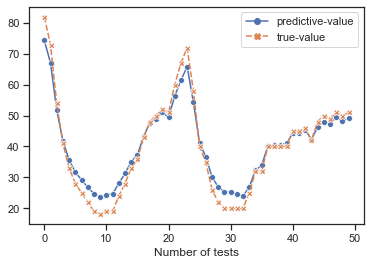

In [287]:
#sns.set(palette="muted", color_codes=True)    # seaborn样式
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
# plt.rcParams['axes.unicode_minus'] = False    # 解决无法显示符号的问题

sns.set_style('ticks')   #默认五种风格：darkgrid，whitegrid，dark，white，ticks
#sns.set(font='SimHei')#, font_scale=0.8)        # 解决Seaborn中文显示问题

fig=sns.lineplot(data=df,markers=True)
plt.xlabel("Number of tests")
#plt.ylabel("test value")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/CS-BP-Adaboost-Predict', dpi = 400)

In [111]:
True_result = np.array(TestY.values)
True_result

array([82, 73, 54, 41, 33, 28, 25, 22, 19, 18, 19, 19, 24, 28, 33, 36, 43,
       48, 50, 52, 51, 60, 67, 72, 58, 40, 35, 26, 22, 20, 20, 20, 20, 25,
       32, 32, 40, 40, 40, 40, 45, 45, 46, 42, 48, 50, 49, 51, 50, 51],
      dtype=int64)

In [112]:
diff_result = abs(True_result-result)
len(diff_result)

50

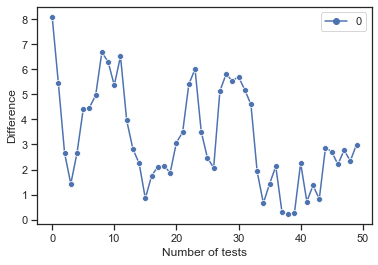

In [113]:
x = list(range(0,len(diff_result)))
fig=sns.lineplot(data = pd.DataFrame(diff_result),markers=True)
plt.xlabel("Number of tests")
plt.ylabel("Difference")
#plt.ylabel("test value")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./pic/CS-BP-Predict-diff', dpi = 400)